In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# this is the code for the convtrans
import os
import sys
import argparse
import logging
import joblib
import pickle
import time
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from art import *
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), '..'))
from Dataset.my_dataset import MyDataset, custom_collate_fn

from Model.resnet50 import ResNet50
from torch.optim import Adam, RAdam

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# prepare data
split_table = pd.read_csv('F:/Cellery/merry/data/label_window/split_table/ECG_Rate/split_table.csv')
train_data_filenames = split_table[split_table['split'] == 'train']['name'].apply(lambda x: x+'_combined.npz').tolist()
test_data_filenames = split_table[split_table['split'] == 'test']['name'].apply(lambda x: x+'_combined.npz').tolist()
data_base_dir = 'G:/Cellery/merry/data/combined/'

model_path_dict = {
    '010000': 'G:/Cellery/merry/Local_classifacation/ConvTran/output/20241125134130_010000/model.pth',
    '111000': 'G:/Cellery/merry/Local_classifacation/ConvTran/output/20241221165750_111000/model.pth',
    '1n0000': 'G:/Cellery/merry/Local_classifacation/ConvTran/output/20241231114404_1n0nnn/model.pth',
    'nnn100': 'G:/Cellery/merry/Local_classifacation/ConvTran/output/20241231090821_nnn100/model.pth',
}

decision_th = 0.5

max_len = 200

In [6]:
train_dataset = MyDataset(
    data_base_dir,
    train_data_filenames,
    model_path_dict=model_path_dict,
    decision_th = decision_th,
    max_len=max_len
)

test_dataset = MyDataset(
    data_base_dir,
    test_data_filenames,
    model_path_dict=model_path_dict,
    decision_th = decision_th,
    max_len=max_len
)

# take 0.2 of the training data as validation data
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.8), len(train_dataset)-int(len(train_dataset)*0.8)])

100%|██████████| 627/627 [01:48<00:00,  5.77it/s]
g:\Cellery\venv\myenv38\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
g:\Cellery\venv\myenv38\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 157/157 [00:22<00:00,  6.88it/s]


In [7]:
print(len(train_dataset))

500


torch.Size([156, 200, 4]) torch.Size([156, 200]) torch.Size([156, 200])


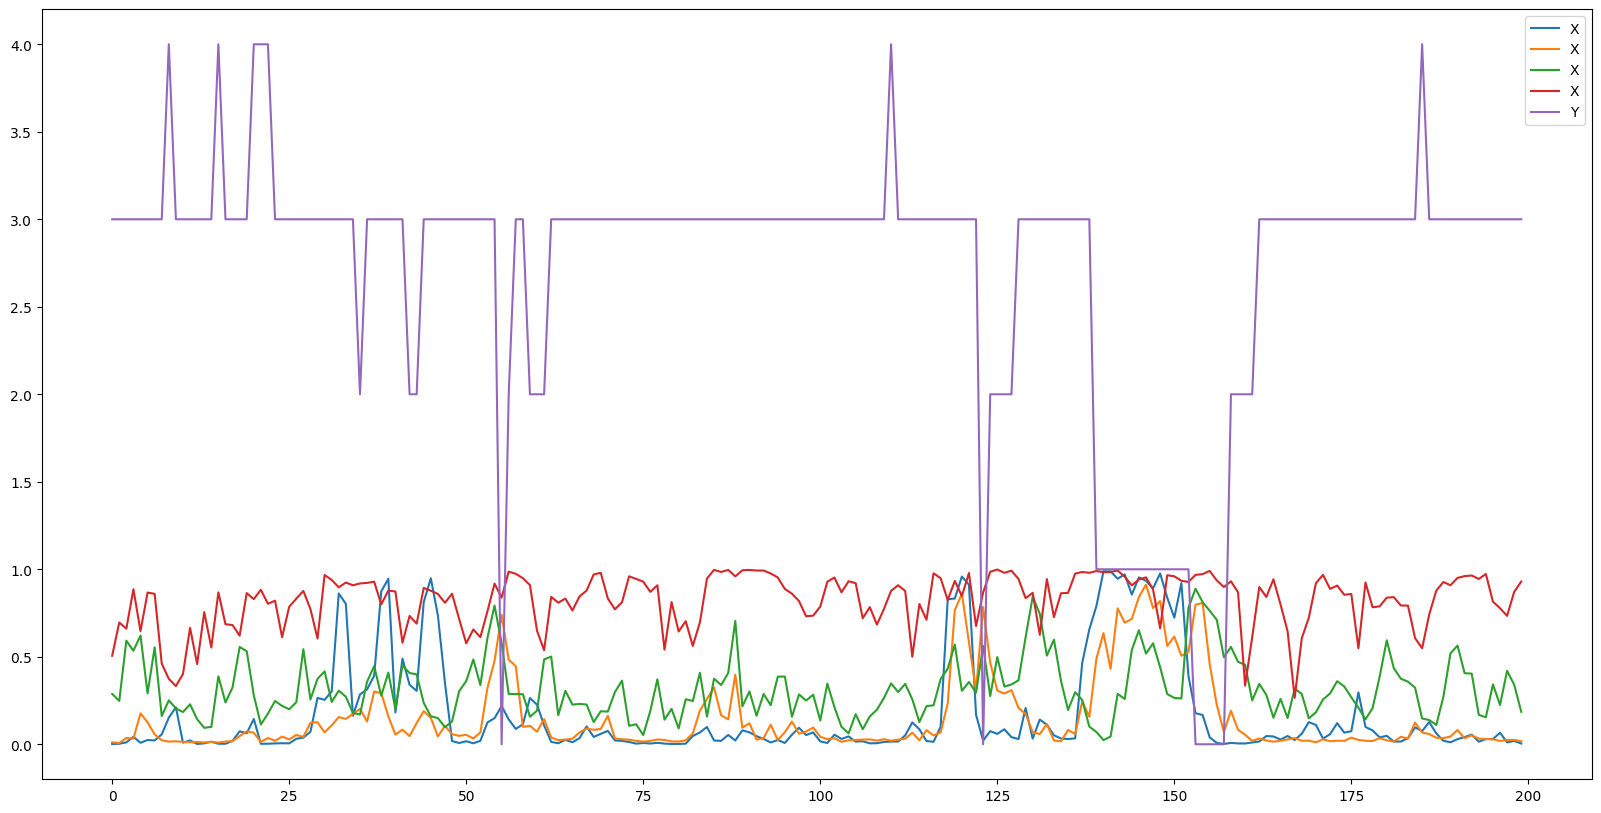

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=0,
    collate_fn=custom_collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=0,
    collate_fn=custom_collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=0,
    collate_fn=custom_collate_fn,
)

for X, Y, mask in test_loader:
    # plot X[0] and Y[0]
    print(X.shape, Y.shape, mask.shape)
    plt.figure(figsize=(20, 10))
    plt.plot(X[0], label='X')
    plt.plot(Y[0], label='Y')
    plt.legend()
    plt.show()
    break

In [9]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=1.5, alpha=0.3):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target):
        pt = target * input + (1 - target) * (1 - input)
        ce = -torch.log(pt)
        loss = self.alpha * (1 - pt) ** self.gamma * ce
        return loss.mean()

In [10]:
from Model.resnet50 import ResNet50
from Model.resnet50 import UNet
# model = ResNet50(in_channels=1,classes=300).to(device)
model = UNet(n_channels=4,n_classes=5, bilinear=True).to(device)

# loss_module = FocalLoss()
loss_module = torch.nn.BCELoss()
optimizer = RAdam(model.parameters(), lr=1e-4)

EPOCHS = 500

Epoch 0 | Train Loss: 0.6916996240615845 | Val Loss: 0.6794959306716919
Epoch 1 | Train Loss: 0.6916363835334778 | Val Loss: 0.6820037364959717
Epoch 2 | Train Loss: 0.6912409067153931 | Val Loss: 0.6836929321289062
Epoch 3 | Train Loss: 0.6913221478462219 | Val Loss: 0.6850714683532715
Epoch 4 | Train Loss: 0.6918966174125671 | Val Loss: 0.686359167098999
Epoch 5 | Train Loss: 0.6917504072189331 | Val Loss: 0.6888669729232788
Epoch 6 | Train Loss: 0.6906065344810486 | Val Loss: 0.6897410750389099
Epoch 7 | Train Loss: 0.6900944113731384 | Val Loss: 0.6915074586868286
Epoch 8 | Train Loss: 0.6883813738822937 | Val Loss: 0.6922531127929688
Epoch 9 | Train Loss: 0.688452959060669 | Val Loss: 0.6955774426460266
Epoch 10 | Train Loss: 0.6871660351753235 | Val Loss: 0.6969467401504517
Epoch 11 | Train Loss: 0.6847988963127136 | Val Loss: 0.6971469521522522
Epoch 12 | Train Loss: 0.6846227645874023 | Val Loss: 0.6993687152862549
Epoch 13 | Train Loss: 0.6821001768112183 | Val Loss: 0.7016536

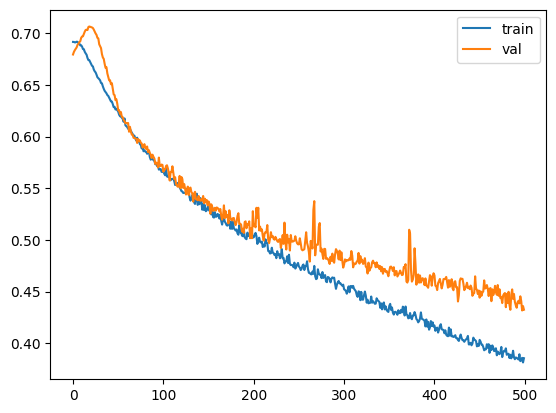

In [11]:
all_train_losses = []
all_val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    for i, (X, Y, mask) in enumerate(train_loader):
        X = X.to(device)
        Y = Y.to(device)
        mask = mask.to(device)

        # one hot encoding for Y
        Y = torch.tensor(np.eye(5)[Y.cpu().numpy().astype(np.int8)]).permute(0, 2, 1).float().to(device)

        # X = (X >= 0.5).float()
        pred = model(X.permute(0, 2, 1))
        loss = loss_module(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            epoch_loss += loss.item()  # add total loss of batch

    epoch_loss = epoch_loss / len(train_loader)
    all_train_losses.append(epoch_loss)

    # validation
    model.eval()
    val_loss = 0
    val_total_samples = 0
    with torch.no_grad():
        for i, (X_test, Y_test, mask) in enumerate(val_loader):
            X_test = X_test.to(device)
            Y_test = Y_test.to(device)
            mask = mask.to(device)

            Y_test = torch.tensor(np.eye(5)[Y_test.cpu().numpy().astype(np.int8)]).permute(0, 2, 1).float().to(device)

            pred = model(X_test.permute(0, 2, 1))
            loss = loss_module(pred, Y_test)
            val_loss += loss

        val_loss = val_loss / len(val_loader)
        all_val_losses.append(val_loss.item())
    
    # print(f'Epoch {epoch} | Train Loss: {epoch_loss}')
    print(f'Epoch {epoch} | Train Loss: {epoch_loss} | Val Loss: {val_loss}')


plt.plot(all_train_losses, label='train')
plt.plot(all_val_losses, label='val')
plt.legend()

In [12]:
# save model
import time
curr = time.strftime("%Y%m%d%H%M%S", time.localtime())
os.makedirs(f'./output/{curr}', exist_ok=True)
torch.save(model.state_dict(), f'./output/{curr}/model.pth')
print(f'model saved to ./output/{curr}/model.pth')

model saved to ./output/20250102105352/model.pth


In [13]:
# load model
# model = ResNet50(in_channels=1,classes=200).to(device)
# model.load_state_dict(torch.load(f'./output/20241221213954/model.pth'))

In [14]:
def pred_decoder(pred):
    """
    1. REM - NREM (010000)
    2. Wake, REM, N1 - N2, N3 (111000)
    3. Wake - N1 (1n0nnn)
    4. N2 - N3 (nnn100)
    """
    print(pred.shape)

torch.Size([156, 200, 4]) (156, 200) (156, 200)


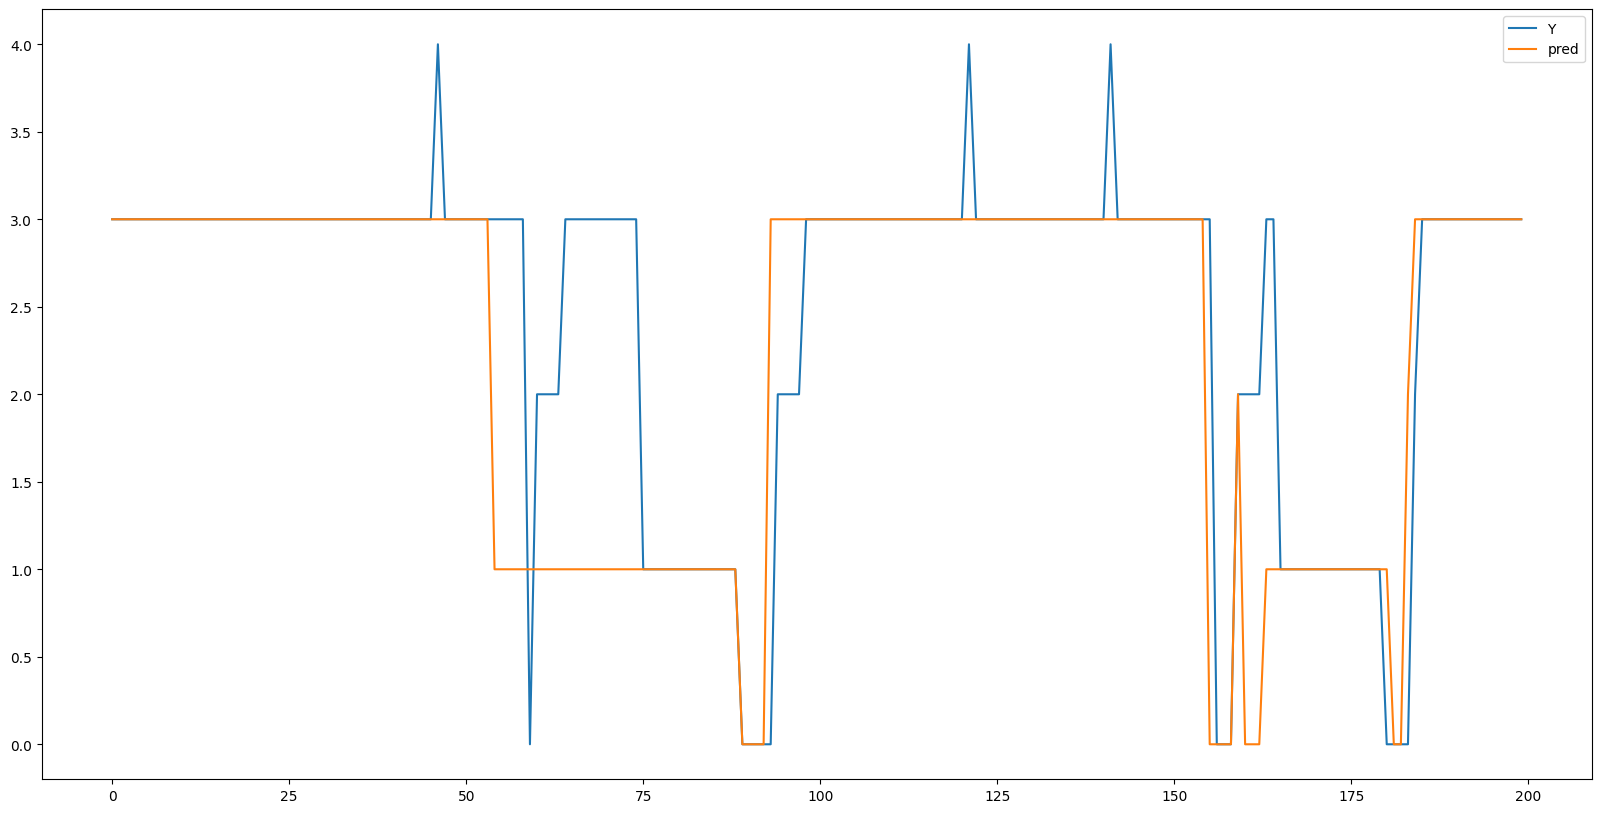

Test Loss: 0.4556567072868347


In [15]:
# test
model.eval()
total_loss = 0
total_samples = 0
for i, (X, Y, mask) in enumerate(test_loader):
    X = X.to(device)
    Y = Y.to(device)
    mask = mask.to(device)

    Y = torch.tensor(np.eye(5)[Y.cpu().numpy().astype(np.int8)]).permute(0, 2, 1).float().to(device)

    pred = model(X.permute(0, 2, 1))
    loss = loss_module(pred, Y)
    total_loss += loss


    pred = (pred >= 0.5).float()
    

    Y = np.argmax(Y.cpu().numpy(), axis=1)
    pred = np.argmax(pred.cpu().detach().numpy(), axis=1)

    print(X.shape, Y.shape, pred.shape)
    
    plt.figure(figsize=(20, 10))
    # plt.plot(X[0].cpu().numpy(), label='X')
    plt.plot(Y[0], label='Y')
    plt.plot(pred[0], label='pred')
    plt.legend()
    plt.show()

print(f'Test Loss: {total_loss.item() / len(test_loader)}')

In [16]:

{
    '11': 0, # wake
    '12': 1, # REM
    '13': 2, # N1
    '14': 3, # N2
    '15': 4, # N3
    '16': 4, # N4
}

{'11': 0, '12': 1, '13': 2, '14': 3, '15': 4, '16': 4}

In [17]:
def X_decoder(x):
    """
    1. REM - NREM               (010000)
    2. Wake, REM, N1 - N2, N3   (111000)
    3. Wake - N1                (1n0nnn)
    4. N2 - N3                  (nnn100)
    x: (batch_size, L, 4)
    """

    # 011x
    x_out = np.zeros((x.shape[0], x.shape[1]))
    for b in range(x.shape[0]):
        for i in range(x.shape[1]):
            if x[b, i, 0]:
                x_out[b, i] = 1 # REM
            else:
                if x[b, i, 1]:
                    if x[b, i, 2]:
                        x_out[b, i] = 2 # N1
                    else:
                        x_out[b, i] = 0 # Wake
                else:
                    if x[b, i, 3]:
                        x_out[b, i] = 3 # N2
                    else:
                        x_out[b, i] = 4 # N3/4
                        
    return x_out

(156, 200) (156, 200) (156, 200)
Test
evaulation of pre-transformer:
[[0.12 0.1  0.52 0.25 0.  ]
 [0.09 0.64 0.1  0.17 0.  ]
 [0.31 0.12 0.17 0.39 0.  ]
 [0.08 0.09 0.05 0.78 0.01]
 [0.03 0.05 0.03 0.88 0.01]]
0.33116943263530585


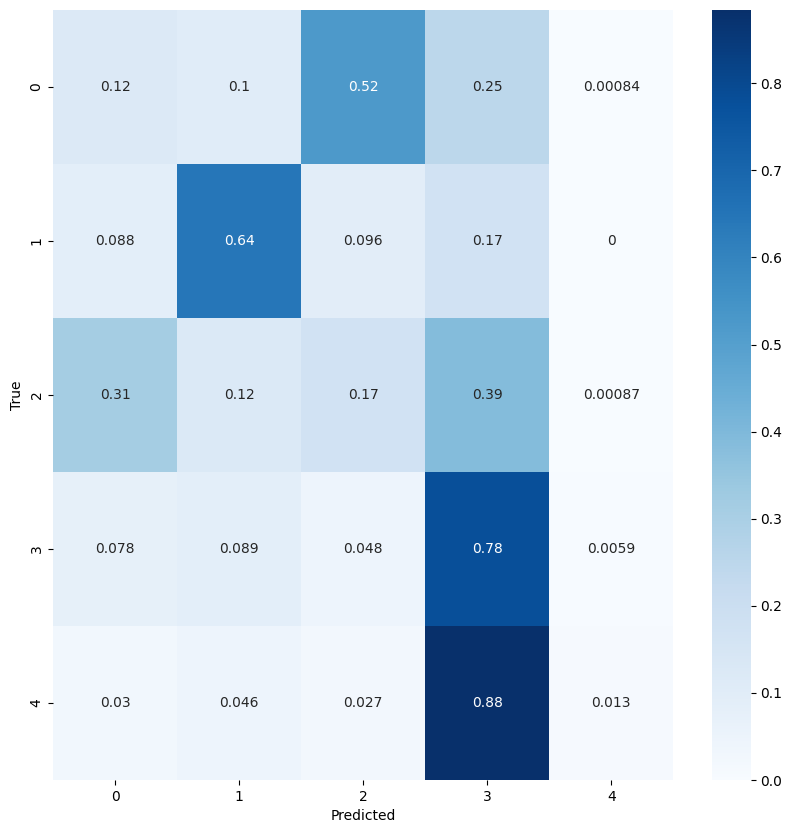


evaulation of post-transformer:
[[0.56 0.1  0.18 0.16 0.01]
 [0.03 0.81 0.06 0.11 0.  ]
 [0.14 0.12 0.38 0.35 0.01]
 [0.04 0.05 0.12 0.77 0.02]
 [0.   0.02 0.03 0.84 0.11]]
0.5100850659909321


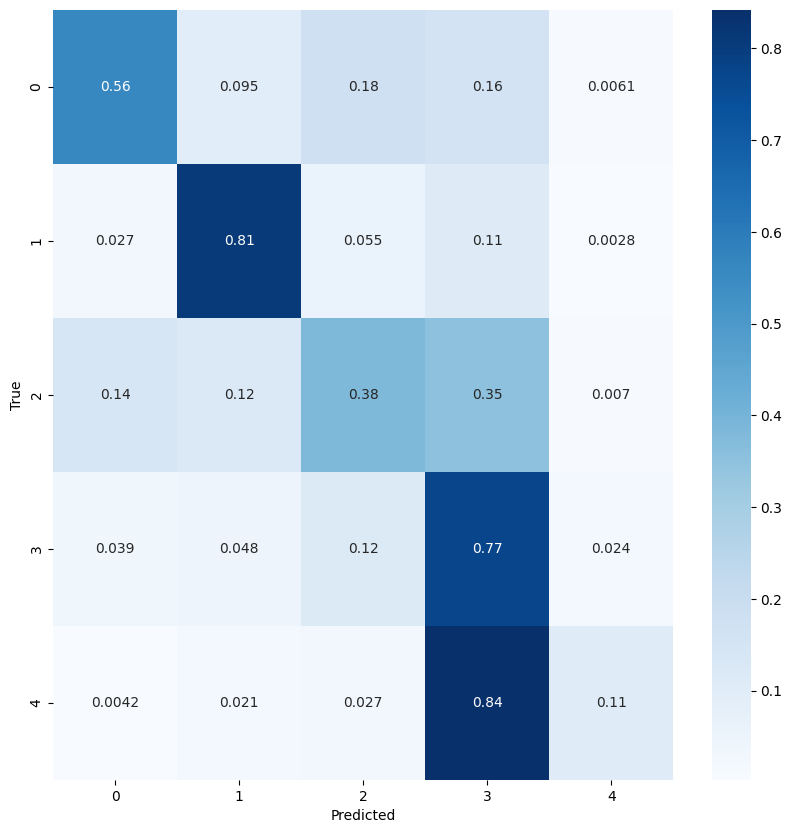

In [18]:
# test
model.eval()
total_loss = 0
total_samples = 0

all_pred_org = []
all_pred = []
all_Y = []

all_preds_plot = []
all_labels_plot = []

for i, (X, Y, mask) in enumerate(test_loader):
    X = X.to(device)
    Y = Y.to(device)
    mask = mask.to(device)

    Y = torch.tensor(np.eye(5)[Y.cpu().numpy().astype(np.int8)]).permute(0, 2, 1).float().to(device)

    pred = model(X.permute(0, 2, 1))
    loss = loss_module(pred, Y)
    total_loss += loss

    Y = np.argmax(Y.cpu().numpy(), axis=1)
    pred = np.argmax(pred.cpu().detach().numpy(), axis=1)

    all_preds_plot.extend(pred)
    all_labels_plot.extend(Y)

    pred_org = (X >= 0.5).float()
    # pred = (pred >= 0.5).float()

    pred_org = X_decoder(pred_org)

    print(pred_org.shape, Y.shape, pred.shape)


    all_pred_org.extend(pred_org)
    all_pred.extend(pred)
    all_Y.extend(Y)

# calc mcc
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

all_pred_org = np.array(all_pred_org).reshape(-1)
all_pred = np.array(all_pred).reshape(-1)
all_Y = np.array(all_Y).reshape(-1)



print("Test")
print('evaulation of pre-transformer:')
cm = confusion_matrix(all_Y, all_pred_org)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(np.round(cm, 2))
print(matthews_corrcoef(all_Y, all_pred_org))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print()

print('evaulation of post-transformer:')
cm = confusion_matrix(all_Y, all_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(np.round(cm, 2))
print(matthews_corrcoef(all_Y, all_pred))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [19]:
# train
model.eval()
total_loss = 0
total_samples = 0

all_pred_org = []
all_pred = []
all_Y = []

all_preds_plot = []
all_labels_plot = []

for i, (X, Y, mask) in enumerate(train_loader):
    X = X.to(device)
    Y = Y.to(device)
    mask = mask.to(device)

    pred = model(X.unsqueeze(1)).squeeze(1)
    loss = loss_module(pred, Y.squeeze(1))
    total_loss += loss

    all_preds_plot.extend(pred.flatten().detach().cpu().numpy())
    all_labels_plot.extend(Y.flatten().detach().cpu().numpy())

    pred_org = (X >= 0.5).float()
    pred = (pred >= 0.5).float()

    all_pred_org.extend(pred_org.cpu().numpy())
    all_pred.extend(pred.cpu().numpy())
    all_Y.extend(Y.cpu().numpy())

# calc mcc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

all_pred_org = np.array(all_pred_org).reshape(-1)
all_pred = np.array(all_pred).reshape(-1)
all_Y = np.array(all_Y).reshape(-1)

print("Train")
print('evaulation of pre-transformer:')
print(confusion_matrix(all_Y, all_pred_org))
print(matthews_corrcoef(all_Y, all_pred_org))
print()
print('evaulation of post-transformer:')
print(confusion_matrix(all_Y, all_pred))
print(matthews_corrcoef(all_Y, all_pred))


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [500, 1, 200, 4]

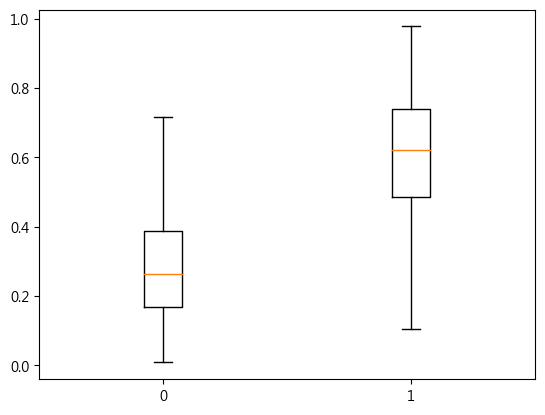

In [30]:
all_labels_plot = np.array(all_labels_plot).astype(int)
all_preds_plot = np.array(all_preds_plot).astype(float)

ind0 = np.where(all_labels_plot == 0)
ind1 = np.where(all_labels_plot == 1)

# boxplot
plt.figure()
plt.boxplot([all_preds_plot[ind0], all_preds_plot[ind1]], labels=['0', '1'], showfliers=False)
plt.show()